In [1]:
# Jupyter Notebook: Risky Location Model for Personal Security Solution

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os

# Step 1: Load and preprocess crime data
# Option A: Knoema Tunisia Crime Data (preferred)
# Instructions: Visit https://knoema.com/atlas/Tunisia/datasets, search for "Crime Statistics"
# Download CSV with columns like 'Latitude', 'Longitude', 'Crime Type', 'Date'
# If geolocation is missing, contact Knoema support or use Option B
knoema_file = 'tunisia_crime_data.csv'  # Replace with your downloaded file path

# Option B: Chicago Crime Data as fallback
chicago_file = 'chicago_crime_data.csv'  # Local cache for Chicago data
url = 'https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD'

if os.path.exists(knoema_file):
    df = pd.read_csv(knoema_file, usecols=['Latitude', 'Longitude', 'Crime Type', 'Date'])
    print("Loaded Knoema Tunisia Crime Data")
elif os.path.exists(chicago_file):
    df = pd.read_csv(chicago_file, usecols=['Latitude', 'Longitude', 'Primary Type', 'Date'], nrows=10000)
    print("Loaded local Chicago Crime Data")
else:
    print("Downloading Chicago Crime Data as proxy.")
    df = pd.read_csv(url, usecols=['Latitude', 'Longitude', 'Primary Type', 'Date'], nrows=10000)
    df.to_csv(chicago_file, index=False)  # Save locally to avoid re-download
    print(f"Saved Chicago data to {chicago_file}")
# Drop rows with missing coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])

# Filter for violent crimes (adjust based on dataset)
violent_crimes = ['ASSAULT', 'BATTERY', 'ROBBERY', 'HOMICIDE']  # For Chicago data
# For Knoema, check available crime types and update (e.g., 'Felony', 'Assault')
df = df[df['Primary Type'].isin(violent_crimes)]  # Replace 'Primary Type' with Knoema's column name

# Extract features: latitude and longitude
X = df[['Latitude', 'Longitude']].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply DBSCAN clustering to identify high-risk areas
dbscan = DBSCAN(eps=0.1, min_samples=10, metric='euclidean')  # Tune eps for Tunisia (e.g., 0.05 for denser areas)
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['Cluster'] = clusters


Knoema data not found. Using Chicago Crime Data as proxy.


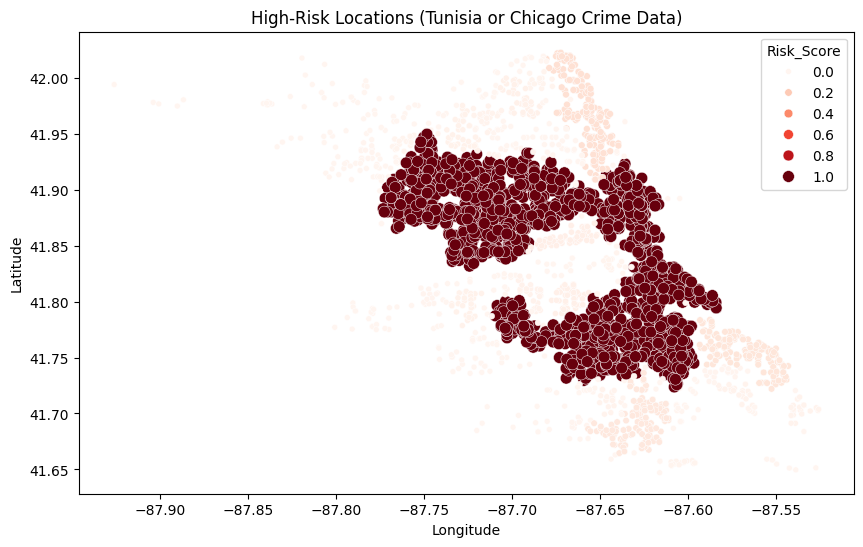

In [2]:

# Step 3: Assign risk scores
# Clusters with more points are riskier; -1 indicates noise (low risk)
cluster_counts = df[df['Cluster'] != -1]['Cluster'].value_counts()
df['Risk_Score'] = df['Cluster'].map(cluster_counts).fillna(0) / cluster_counts.max()  # Normalize to 0-1

# Step 4: Visualize results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Risk_Score', size='Risk_Score', palette='Reds')
plt.title('High-Risk Locations (Tunisia or Chicago Crime Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [8]:

# Step 5: Function to predict risk score for new location
def predict_risk_score(lat, lon, model, scaler, cluster_counts):
    X_new = np.array([[lat, lon]])
    X_new_scaled = scaler.transform(X_new)
    cluster = model.fit_predict(X_new_scaled)[0]  # Note: DBSCAN predict is limited; refit for simplicity
    return cluster_counts.get(cluster, 0) / cluster_counts.max() if cluster != -1 else 0.0

# Example prediction (use Tunis coordinates, e.g., Tunis city center)
sample_lat, sample_lon = 36.8065, -20.4788  # Tunis, Tunisia
sample_lat2, sample_lon2 = 41.8781, -87.6298
risk_score = predict_risk_score(sample_lat, sample_lon, dbscan, scaler, cluster_counts)
print(f'Risk Score for ({sample_lat}, {sample_lon}): {risk_score:.2f}')



Risk Score for (36.8065, -20.4788): 0.00


In [7]:
# Step 6: Save model
import joblib
joblib.dump(dbscan, 'risky_location_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']